## **PIP install**

In [5]:
!pip install segmentation_models_pytorch
!pip install sklearn

## **Import modules and Packages**

In [5]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import albumentations as A
from albumentations import RandomResizedCrop
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.augmentations.geometric.rotate import RandomRotate90
from albumentations.augmentations.transforms import HorizontalFlip, VerticalFlip
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from pytorch_toolbelt import losses

from sklearn.model_selection import GroupKFold, KFold

from torch.cuda.amp import autocast, GradScaler

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors
%matplotlib inline

plt.rcParams['axes.grid'] = False

print('Pytorch version: {}'.format(torch.__version__))
print('GPU: {}'.format(torch.cuda.is_available()))

print('Device name: ', torch.cuda.get_device_name(0))
print('Device count: ', torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

Pytorch version: 1.9.1+cu102
GPU: True
Device name:  Tesla V100-SXM2-32GB
Device count:  1


In [6]:
!nvidia-smi

Thu Oct 21 00:38:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    51W / 300W |  17052MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Set Configs**

In [7]:
CFG = {
    'batch_size':16,
    'num_epochs':25,
    'lr':1e-4,
    'seed':21,
    'n_classes':11,
    'experiment_number':'1021',
    'encoder_model':'resnext50_32x4d'
}

## **Utils**

In [8]:
import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                        minlength=n_class ** 2).reshape(n_class, n_class) 
    return hist


def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu


def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    return hist


def seed_everythind(seed):
    """
        Fix seed
    """
    random_seed = seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)


class_colormap = pd.read_csv("../class_dict.csv")
class_colormap

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [9]:
seed_everythind(CFG['seed'])

## **Define Dataframe(df)**

In [10]:
dataset_path  = '../../input'
train_path = dataset_path + '/train_all.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

def data_frame(anns_file_path): # for psudo
    with open(anns_file_path, 'r') as f:
        dataset = json.loads(f.read())
    
    categories = dataset['categories']
    anns = dataset['annotations']
    imgs = dataset['images']

    nr_cats = len(categories)
    nr_annotations = len(anns)
    nr_images = len(imgs)

    # Load categories and super categories
    cat_names = []
    super_cat_names = []
    super_cat_ids = {}
    super_cat_last_name = ''
    nr_super_cats = 0
    for cat_it in categories:
        cat_names.append(cat_it['name'])
        super_cat_name = cat_it['supercategory']
        # Adding new supercat
        if super_cat_name != super_cat_last_name:
            super_cat_names.append(super_cat_name)
            super_cat_ids[super_cat_name] = nr_super_cats
            super_cat_last_name = super_cat_name
            nr_super_cats += 1

    # Count annotations
    cat_histogram = np.zeros(nr_cats,dtype=int)
    for ann in anns:
        cat_histogram[ann['category_id']-1] += 1

    # Initialize the matplotlib figure

    # Convert to DataFrame
    df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
    df = df.sort_values('Number of annotations', 0, False)
    return df


# df_t = data_frame(anns_file_path)
# df_p = data_frame(psud_file_path)

# df = pd.concat([df_t, df_p], ignore_index=True)
# df = pd.DataFrame()
# for dataframe, colums in df_p:
#     if dataframe in df_t['Categories']:
#         df.append()
# category labeling 
df = data_frame(train_path)
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


## **CustomDataLoader**

In [11]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## **Dataset and Dataloader**

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
def get_augmentation(data_dir):
    if data_dir == 'train':
        return A.Compose([
                        OneOf([
                            RandomResizedCrop(height=512,width=512,p=1.0),
                            HorizontalFlip(p=1.0),
                            VerticalFlip(p=1.0),
                        ],p=1.0),
                        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        A.RandomRotate90(p=1.0),
                        A.Cutout(p=0.75),
                        ToTensorV2()
                        ])
    else:
        return A.Compose([
                        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()
                        ])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=get_augmentation('train'))
    
train_loader = DataLoader(
    dataset=train_dataset, batch_size=CFG['batch_size'], shuffle=True, num_workers=0, collate_fn=collate_fn)
        
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=get_augmentation('val'))

val_loader = DataLoader(
    dataset=val_dataset, batch_size=CFG['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)

def inference_dataloader():
    test_path = dataset_path + '/test.json'

    test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=get_augmentation('test'))
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=CFG['batch_size'], num_workers=0, collate_fn=collate_fn)
    return test_loader

In [14]:
test_path = dataset_path + '/test.json'

test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=get_augmentation('test'))
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=CFG['batch_size'], num_workers=0, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## **Define Model**

In [15]:
model = smp.DeepLabV3Plus(
    encoder_name=CFG['encoder_model'],
    encoder_weights="swsl",
    in_channels=3,
    classes=11).to(device)

### **Model Test**

In [16]:
x = torch.randn([2, 3, 512, 512]).to(device)
print(f"input shape : {x.shape}")
out = model(x)
print(f"output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512])
output shape : torch.Size([2, 11, 512, 512])


## **One Epoch**

In [17]:
def train_one(epoch, model, train_loader, criterion, optimizer, device):
    print(f'Start training..')

    model.train()
    hist = np.zeros((CFG['n_classes'], CFG['n_classes']))

    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)

    for step, (images, masks, _) in pbar:

        if (step+1) == (len(train_loader)):
            continue

        images = torch.stack(images).float()       
        masks = torch.stack(masks).long() 
        
        # to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Autocast
        with autocast():
            model = model.to(device)
            
            # inference
            outputs = model(images)
        
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        # loss.backward()
        # optimizer.step()
        
        outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        masks = masks.detach().cpu().numpy()
        
        hist = add_hist(hist, masks, outputs, n_class=CFG['n_classes'])
        mIoU = label_accuracy_score(hist)[2]
        
        description = f'epoch {epoch} Loss: {loss.item():.4f} mIoU: {round(mIoU,4)}'
        pbar.set_description(description)

In [18]:
def val_one(epoch, model, val_loader, criterion, device):
    print(f'Start validation #{epoch}')

    model.eval()
    hist = np.zeros((CFG['n_classes'], CFG['n_classes']))

    total_loss = 0
    cnt = 0

    pbar = tqdm(enumerate(val_loader), total=len(val_loader), position=0, leave=True)

    for step, (images, masks, _) in pbar:
        images = torch.stack(images)       
        masks = torch.stack(masks).long() 
        
        # to device
        images = images.to(device)
        masks = masks.to(device)
        model = model.to(device)

        # inference
        outputs = model(images)

        loss = criterion(outputs, masks)
        total_loss += loss
        cnt += 1

        outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        masks = masks.detach().cpu().numpy()
        
        hist = add_hist(hist, masks, outputs, n_class=CFG['n_classes'])

        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avg_loss = total_loss / cnt

        description = f'Validation #{epoch}  Average Loss: {round(avg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                    mIoU: {round(mIoU, 4)}'
        pbar.set_description(description)                
    return avg_loss, mIoU


## **Make Save dir**

In [19]:
saved_dir = '../saved/' + CFG['experiment_number']

if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name=CFG['experiment_number']+CFG['encoder_model']+'.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## **Define Loss and Optimizer**

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = CFG['lr'],
    weight_decay = 1e-6)

## **Folds**(not finished)

In [21]:
from sklearn.model_selection import StratifiedKFold

FOLDS = 5
df["Folds"] = 0

kf = KFold(FOLDS, shuffle=True, random_state=CFG['seed'])
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    df.loc[val_idx, 'Folds'] = fold


## **Train**

In [47]:
for fold in range(FOLDS):
    print(f'{fold} fold start')
    scaler = GradScaler()

    train_path = dataset_path + '/train.json'
    val_path = dataset_path + '/val.json'

    train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=get_augmentation('train'))
    val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=get_augmentation('val'))
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=CFG['batch_size'], shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=CFG['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)

    best_mIoU = 0

    for epoch in range(CFG['num_epochs']):
        train_one(epoch, model, train_loader, criterion, optimizer, device)

        with torch.no_grad():
            epoch_loss, mIoU = val_one(epoch, model, val_loader, criterion, device)
        
        if best_mIoU < mIoU:
            best_mIoU = mIoU
            save_model(model,saved_dir,file_name=CFG['experiment_number']+'_'+CFG['encoder_model']+'.pt')
            print('model is saved')
            
torch.cuda.empty_cache()


0 fold start
loading annotations into memory...
Done (t=3.42s)
creating index...
index created!
loading annotations into memory...


  0%|          | 0/164 [00:00<?, ?it/s]

Done (t=1.84s)
creating index...
index created!
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #0


Validation #0  Average Loss: 1.1511, Accuracy : 0.845,                     mIoU: 0.2504: 100%|██████████| 41/41 [00:21<00:00,  1.97it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #1


Validation #1  Average Loss: 0.8416, Accuracy : 0.8736,                     mIoU: 0.3155: 100%|██████████| 41/41 [00:19<00:00,  2.37it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #2


Validation #2  Average Loss: 0.7501, Accuracy : 0.8864,                     mIoU: 0.3763: 100%|██████████| 41/41 [00:20<00:00,  2.37it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #3


Validation #3  Average Loss: 0.6366, Accuracy : 0.9032,                     mIoU: 0.4112: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #4


Validation #4  Average Loss: 0.6091, Accuracy : 0.9013,                     mIoU: 0.4399: 100%|██████████| 41/41 [00:20<00:00,  2.28it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #5


Validation #5  Average Loss: 0.6372, Accuracy : 0.8965,                     mIoU: 0.4525: 100%|██████████| 41/41 [00:20<00:00,  2.09it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #6


Validation #6  Average Loss: 0.5706, Accuracy : 0.9049,                     mIoU: 0.4832: 100%|██████████| 41/41 [00:20<00:00,  2.26it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #7


Validation #7  Average Loss: 0.5328, Accuracy : 0.907,                     mIoU: 0.4965: 100%|██████████| 41/41 [00:20<00:00,  2.19it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #8


Validation #8  Average Loss: 0.5267, Accuracy : 0.9059,                     mIoU: 0.4791: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #9


Validation #9  Average Loss: 0.4826, Accuracy : 0.9098,                     mIoU: 0.4823: 100%|██████████| 41/41 [00:19<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #10


Validation #10  Average Loss: 0.4431, Accuracy : 0.9189,                     mIoU: 0.5187: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #11


Validation #11  Average Loss: 0.4301, Accuracy : 0.921,                     mIoU: 0.5297: 100%|██████████| 41/41 [00:21<00:00,  2.31it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #12


Validation #12  Average Loss: 0.4198, Accuracy : 0.9152,                     mIoU: 0.49: 100%|██████████| 41/41 [00:20<00:00,  2.36it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #13


Validation #13  Average Loss: 0.3895, Accuracy : 0.9221,                     mIoU: 0.5337: 100%|██████████| 41/41 [00:19<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #14


Validation #14  Average Loss: 0.3909, Accuracy : 0.9205,                     mIoU: 0.5241: 100%|██████████| 41/41 [00:19<00:00,  2.38it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #15


Validation #15  Average Loss: 0.4231, Accuracy : 0.9166,                     mIoU: 0.4896: 100%|██████████| 41/41 [00:20<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #16


Validation #16  Average Loss: 0.3806, Accuracy : 0.9163,                     mIoU: 0.5136: 100%|██████████| 41/41 [00:20<00:00,  2.26it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #17


Validation #17  Average Loss: 0.3694, Accuracy : 0.9142,                     mIoU: 0.4953: 100%|██████████| 41/41 [00:20<00:00,  2.27it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #18


Validation #18  Average Loss: 0.3436, Accuracy : 0.9205,                     mIoU: 0.5253: 100%|██████████| 41/41 [00:19<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #19


Validation #19  Average Loss: 0.3984, Accuracy : 0.9095,                     mIoU: 0.5194: 100%|██████████| 41/41 [00:19<00:00,  2.09it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #20


Validation #20  Average Loss: 0.3834, Accuracy : 0.9123,                     mIoU: 0.5166: 100%|██████████| 41/41 [00:20<00:00,  2.19it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #21


Validation #21  Average Loss: 0.3501, Accuracy : 0.9176,                     mIoU: 0.5038: 100%|██████████| 41/41 [00:20<00:00,  2.31it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #22


Validation #22  Average Loss: 0.3624, Accuracy : 0.9161,                     mIoU: 0.5367: 100%|██████████| 41/41 [00:19<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #23


Validation #23  Average Loss: 0.3027, Accuracy : 0.9281,                     mIoU: 0.5726: 100%|██████████| 41/41 [00:19<00:00,  2.37it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #24


Validation #24  Average Loss: 0.3113, Accuracy : 0.9243,                     mIoU: 0.5735: 100%|██████████| 41/41 [00:20<00:00,  2.29it/s]


model is saved
1 fold start
loading annotations into memory...
Done (t=3.43s)
creating index...
index created!
loading annotations into memory...


  0%|          | 0/164 [00:00<?, ?it/s]

Done (t=0.87s)
creating index...
index created!
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #0


Validation #0  Average Loss: 0.3092, Accuracy : 0.9228,                     mIoU: 0.5611: 100%|██████████| 41/41 [00:19<00:00,  2.35it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #1


Validation #1  Average Loss: 0.3082, Accuracy : 0.9232,                     mIoU: 0.5724: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #2


Validation #2  Average Loss: 0.3352, Accuracy : 0.9165,                     mIoU: 0.5572: 100%|██████████| 41/41 [00:20<00:00,  2.27it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #3


Validation #3  Average Loss: 0.3212, Accuracy : 0.9207,                     mIoU: 0.5754: 100%|██████████| 41/41 [00:21<00:00,  1.97it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #4


Validation #4  Average Loss: 0.2854, Accuracy : 0.9295,                     mIoU: 0.6182: 100%|██████████| 41/41 [00:20<00:00,  2.29it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #5


Validation #5  Average Loss: 0.3036, Accuracy : 0.9215,                     mIoU: 0.5621: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #6


Validation #6  Average Loss: 0.2864, Accuracy : 0.9247,                     mIoU: 0.5986: 100%|██████████| 41/41 [00:19<00:00,  2.35it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #7


Validation #7  Average Loss: 0.3467, Accuracy : 0.9098,                     mIoU: 0.5338: 100%|██████████| 41/41 [00:20<00:00,  2.20it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #8


Validation #8  Average Loss: 0.3198, Accuracy : 0.9212,                     mIoU: 0.5548: 100%|██████████| 41/41 [00:20<00:00,  1.95it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #9


Validation #9  Average Loss: 0.2738, Accuracy : 0.928,                     mIoU: 0.605: 100%|██████████| 41/41 [00:20<00:00,  2.29it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #10


Validation #10  Average Loss: 0.3067, Accuracy : 0.9211,                     mIoU: 0.5896: 100%|██████████| 41/41 [00:20<00:00,  2.26it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #11


Validation #11  Average Loss: 0.2773, Accuracy : 0.927,                     mIoU: 0.5743: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #12


Validation #12  Average Loss: 0.3006, Accuracy : 0.9223,                     mIoU: 0.5361: 100%|██████████| 41/41 [00:21<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #13


Validation #13  Average Loss: 0.2805, Accuracy : 0.9256,                     mIoU: 0.5885: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #14


Validation #14  Average Loss: 0.2608, Accuracy : 0.9313,                     mIoU: 0.6038: 100%|██████████| 41/41 [00:20<00:00,  2.16it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #15


Validation #15  Average Loss: 0.2885, Accuracy : 0.9226,                     mIoU: 0.586: 100%|██████████| 41/41 [00:20<00:00,  2.01it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #16


Validation #16  Average Loss: 0.2864, Accuracy : 0.9249,                     mIoU: 0.5759: 100%|██████████| 41/41 [00:20<00:00,  2.31it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #17


Validation #17  Average Loss: 0.2633, Accuracy : 0.928,                     mIoU: 0.5816: 100%|██████████| 41/41 [00:20<00:00,  2.36it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #18


Validation #18  Average Loss: 0.2765, Accuracy : 0.9251,                     mIoU: 0.5736: 100%|██████████| 41/41 [00:21<00:00,  2.19it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #19


Validation #19  Average Loss: 0.268, Accuracy : 0.93,                     mIoU: 0.6012: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #20


Validation #20  Average Loss: 0.2978, Accuracy : 0.9234,                     mIoU: 0.5828: 100%|██████████| 41/41 [00:20<00:00,  2.27it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #21


Validation #21  Average Loss: 0.3154, Accuracy : 0.9164,                     mIoU: 0.5345: 100%|██████████| 41/41 [00:20<00:00,  2.27it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #22


Validation #22  Average Loss: 0.2762, Accuracy : 0.9258,                     mIoU: 0.5935: 100%|██████████| 41/41 [00:19<00:00,  2.32it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #23


Validation #23  Average Loss: 0.282, Accuracy : 0.9227,                     mIoU: 0.5869: 100%|██████████| 41/41 [00:20<00:00,  2.26it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #24


Validation #24  Average Loss: 0.2896, Accuracy : 0.925,                     mIoU: 0.5929: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]


2 fold start
loading annotations into memory...
Done (t=4.16s)
creating index...
index created!
loading annotations into memory...


  0%|          | 0/164 [00:00<?, ?it/s]

Done (t=0.87s)
creating index...
index created!
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #0


Validation #0  Average Loss: 0.313, Accuracy : 0.9184,                     mIoU: 0.5462: 100%|██████████| 41/41 [00:20<00:00,  2.16it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #1


Validation #1  Average Loss: 0.2729, Accuracy : 0.9287,                     mIoU: 0.604: 100%|██████████| 41/41 [00:20<00:00,  2.36it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #2


Validation #2  Average Loss: 0.2866, Accuracy : 0.9251,                     mIoU: 0.5759: 100%|██████████| 41/41 [00:19<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #3


Validation #3  Average Loss: 0.2741, Accuracy : 0.9253,                     mIoU: 0.5779: 100%|██████████| 41/41 [00:20<00:00,  2.06it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #4


Validation #4  Average Loss: 0.2815, Accuracy : 0.9254,                     mIoU: 0.5913: 100%|██████████| 41/41 [00:20<00:00,  2.35it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #5


Validation #5  Average Loss: 0.2707, Accuracy : 0.9252,                     mIoU: 0.577: 100%|██████████| 41/41 [00:20<00:00,  2.32it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #6


Validation #6  Average Loss: 0.2852, Accuracy : 0.9246,                     mIoU: 0.5759: 100%|██████████| 41/41 [00:20<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #7


Validation #7  Average Loss: 0.2596, Accuracy : 0.9321,                     mIoU: 0.6201: 100%|██████████| 41/41 [00:20<00:00,  2.18it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #8


Validation #8  Average Loss: 0.2876, Accuracy : 0.9209,                     mIoU: 0.5731: 100%|██████████| 41/41 [00:20<00:00,  2.32it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #9


Validation #9  Average Loss: 0.2931, Accuracy : 0.9192,                     mIoU: 0.5686: 100%|██████████| 41/41 [00:20<00:00,  2.30it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #10


Validation #10  Average Loss: 0.2751, Accuracy : 0.9259,                     mIoU: 0.5526: 100%|██████████| 41/41 [00:20<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #11


Validation #11  Average Loss: 0.2987, Accuracy : 0.924,                     mIoU: 0.5219: 100%|██████████| 41/41 [00:20<00:00,  2.26it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #12


Validation #12  Average Loss: 0.2825, Accuracy : 0.9291,                     mIoU: 0.6016: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #13


Validation #13  Average Loss: 0.281, Accuracy : 0.9298,                     mIoU: 0.6002: 100%|██████████| 41/41 [00:20<00:00,  2.31it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #14


Validation #14  Average Loss: 0.2748, Accuracy : 0.9298,                     mIoU: 0.6013: 100%|██████████| 41/41 [00:20<00:00,  2.31it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #15


Validation #15  Average Loss: 0.3084, Accuracy : 0.9237,                     mIoU: 0.5647: 100%|██████████| 41/41 [00:20<00:00,  2.32it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #16


Validation #16  Average Loss: 0.2825, Accuracy : 0.9247,                     mIoU: 0.5948: 100%|██████████| 41/41 [00:20<00:00,  2.32it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #17


Validation #17  Average Loss: 0.294, Accuracy : 0.9272,                     mIoU: 0.6084: 100%|██████████| 41/41 [00:20<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #18


Validation #18  Average Loss: 0.2689, Accuracy : 0.9307,                     mIoU: 0.612: 100%|██████████| 41/41 [00:20<00:00,  2.26it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #19


Validation #19  Average Loss: 0.2961, Accuracy : 0.925,                     mIoU: 0.5902: 100%|██████████| 41/41 [00:19<00:00,  2.25it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #20


Validation #20  Average Loss: 0.3034, Accuracy : 0.9226,                     mIoU: 0.5705: 100%|██████████| 41/41 [00:20<00:00,  2.34it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #21


Validation #21  Average Loss: 0.2815, Accuracy : 0.9228,                     mIoU: 0.5992: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #22


Validation #22  Average Loss: 0.2981, Accuracy : 0.9222,                     mIoU: 0.5792: 100%|██████████| 41/41 [00:20<00:00,  2.33it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #23


Validation #23  Average Loss: 0.2796, Accuracy : 0.9261,                     mIoU: 0.5939: 100%|██████████| 41/41 [00:19<00:00,  2.36it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #24


Validation #24  Average Loss: 0.2744, Accuracy : 0.9327,                     mIoU: 0.6037: 100%|██████████| 41/41 [00:19<00:00,  2.31it/s]


3 fold start
loading annotations into memory...
Done (t=4.23s)
creating index...
index created!
loading annotations into memory...


  0%|          | 0/164 [00:00<?, ?it/s]

Done (t=0.86s)
creating index...
index created!
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #0


Validation #0  Average Loss: 0.2902, Accuracy : 0.9321,                     mIoU: 0.5696: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #1


Validation #1  Average Loss: 0.2799, Accuracy : 0.9298,                     mIoU: 0.5771: 100%|██████████| 41/41 [00:20<00:00,  2.21it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #2


Validation #2  Average Loss: 0.2877, Accuracy : 0.9247,                     mIoU: 0.5881: 100%|██████████| 41/41 [00:21<00:00,  2.22it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #3


Validation #3  Average Loss: 0.2863, Accuracy : 0.9281,                     mIoU: 0.6063: 100%|██████████| 41/41 [00:21<00:00,  2.20it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #4


Validation #4  Average Loss: 0.2842, Accuracy : 0.9279,                     mIoU: 0.6042: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #5


Validation #5  Average Loss: 0.2814, Accuracy : 0.9307,                     mIoU: 0.608: 100%|██████████| 41/41 [00:21<00:00,  2.17it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #6


Validation #6  Average Loss: 0.2864, Accuracy : 0.9281,                     mIoU: 0.6043: 100%|██████████| 41/41 [00:20<00:00,  2.13it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #7


Validation #7  Average Loss: 0.3047, Accuracy : 0.9229,                     mIoU: 0.5976: 100%|██████████| 41/41 [00:21<00:00,  2.17it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #8


Validation #8  Average Loss: 0.3019, Accuracy : 0.926,                     mIoU: 0.575: 100%|██████████| 41/41 [00:20<00:00,  2.22it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #9


Validation #9  Average Loss: 0.2682, Accuracy : 0.9323,                     mIoU: 0.6287: 100%|██████████| 41/41 [00:20<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #10


Validation #10  Average Loss: 0.2788, Accuracy : 0.9311,                     mIoU: 0.5948: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #11


Validation #11  Average Loss: 0.2847, Accuracy : 0.9317,                     mIoU: 0.6239: 100%|██████████| 41/41 [00:20<00:00,  2.21it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #12


Validation #12  Average Loss: 0.3086, Accuracy : 0.9287,                     mIoU: 0.5861: 100%|██████████| 41/41 [00:21<00:00,  2.07it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #13


Validation #13  Average Loss: 0.2853, Accuracy : 0.9278,                     mIoU: 0.6088: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #14


Validation #14  Average Loss: 0.2611, Accuracy : 0.9316,                     mIoU: 0.6425: 100%|██████████| 41/41 [00:20<00:00,  2.20it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #15


Validation #15  Average Loss: 0.2819, Accuracy : 0.9258,                     mIoU: 0.6074: 100%|██████████| 41/41 [00:20<00:00,  2.16it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #16


Validation #16  Average Loss: 0.3248, Accuracy : 0.9211,                     mIoU: 0.5749: 100%|██████████| 41/41 [00:21<00:00,  2.01it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #17


Validation #17  Average Loss: 0.297, Accuracy : 0.9248,                     mIoU: 0.5725: 100%|██████████| 41/41 [00:20<00:00,  2.18it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #18


Validation #18  Average Loss: 0.2977, Accuracy : 0.9268,                     mIoU: 0.5911: 100%|██████████| 41/41 [00:22<00:00,  2.20it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #19


Validation #19  Average Loss: 0.3192, Accuracy : 0.9271,                     mIoU: 0.5942: 100%|██████████| 41/41 [00:21<00:00,  2.12it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #20


Validation #20  Average Loss: 0.293, Accuracy : 0.9275,                     mIoU: 0.5672: 100%|██████████| 41/41 [00:21<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #21


Validation #21  Average Loss: 0.3235, Accuracy : 0.919,                     mIoU: 0.5488: 100%|██████████| 41/41 [00:21<00:00,  2.05it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #22


Validation #22  Average Loss: 0.3353, Accuracy : 0.9103,                     mIoU: 0.5389: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #23


Validation #23  Average Loss: 0.2947, Accuracy : 0.9278,                     mIoU: 0.5987: 100%|██████████| 41/41 [00:21<00:00,  2.21it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #24


Validation #24  Average Loss: 0.3123, Accuracy : 0.9299,                     mIoU: 0.6176: 100%|██████████| 41/41 [00:21<00:00,  2.21it/s]


4 fold start
loading annotations into memory...
Done (t=4.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #0


Validation #0  Average Loss: 0.401, Accuracy : 0.9047,                     mIoU: 0.5016: 100%|██████████| 41/41 [00:21<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #1


Validation #1  Average Loss: 0.3013, Accuracy : 0.9305,                     mIoU: 0.574: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #2


Validation #2  Average Loss: 0.2976, Accuracy : 0.9277,                     mIoU: 0.602: 100%|██████████| 41/41 [00:20<00:00,  2.27it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #3


Validation #3  Average Loss: 0.2977, Accuracy : 0.9247,                     mIoU: 0.6025: 100%|██████████| 41/41 [00:21<00:00,  2.11it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #4


Validation #4  Average Loss: 0.2882, Accuracy : 0.93,                     mIoU: 0.6024: 100%|██████████| 41/41 [00:20<00:00,  2.25it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #5


Validation #5  Average Loss: 0.2962, Accuracy : 0.9302,                     mIoU: 0.6042: 100%|██████████| 41/41 [00:20<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #6


Validation #6  Average Loss: 0.29, Accuracy : 0.9328,                     mIoU: 0.6142: 100%|██████████| 41/41 [00:21<00:00,  2.19it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #7


Validation #7  Average Loss: 0.3579, Accuracy : 0.9216,                     mIoU: 0.5793: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #8


Validation #8  Average Loss: 0.3045, Accuracy : 0.9257,                     mIoU: 0.6023: 100%|██████████| 41/41 [00:22<00:00,  1.88it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #9


Validation #9  Average Loss: 0.284, Accuracy : 0.933,                     mIoU: 0.6021: 100%|██████████| 41/41 [00:21<00:00,  2.20it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #10


Validation #10  Average Loss: 0.3077, Accuracy : 0.9272,                     mIoU: 0.5956: 100%|██████████| 41/41 [00:20<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #11


Validation #11  Average Loss: 0.3253, Accuracy : 0.9247,                     mIoU: 0.5794: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #12


Validation #12  Average Loss: 0.3108, Accuracy : 0.9245,                     mIoU: 0.5793: 100%|██████████| 41/41 [00:20<00:00,  2.22it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #13


Validation #13  Average Loss: 0.3219, Accuracy : 0.9233,                     mIoU: 0.5882: 100%|██████████| 41/41 [00:21<00:00,  2.25it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #14


Validation #14  Average Loss: 0.3098, Accuracy : 0.9274,                     mIoU: 0.6031: 100%|██████████| 41/41 [00:21<00:00,  2.23it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #15


Validation #15  Average Loss: 0.3089, Accuracy : 0.9307,                     mIoU: 0.6264: 100%|██████████| 41/41 [00:21<00:00,  2.25it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #16


Validation #16  Average Loss: 0.2999, Accuracy : 0.9303,                     mIoU: 0.6179: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #17


Validation #17  Average Loss: 0.2898, Accuracy : 0.9302,                     mIoU: 0.612: 100%|██████████| 41/41 [00:21<00:00,  2.22it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #18


Validation #18  Average Loss: 0.2897, Accuracy : 0.9295,                     mIoU: 0.5979: 100%|██████████| 41/41 [00:20<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #19


Validation #19  Average Loss: 0.2841, Accuracy : 0.9329,                     mIoU: 0.634: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

model is saved
Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #20


Validation #20  Average Loss: 0.3003, Accuracy : 0.9319,                     mIoU: 0.625: 100%|██████████| 41/41 [00:21<00:00,  2.19it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #21


Validation #21  Average Loss: 0.3116, Accuracy : 0.9275,                     mIoU: 0.6042: 100%|██████████| 41/41 [00:20<00:00,  2.12it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #22


Validation #22  Average Loss: 0.293, Accuracy : 0.9309,                     mIoU: 0.5869: 100%|██████████| 41/41 [00:21<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #23


Validation #23  Average Loss: 0.283, Accuracy : 0.9312,                     mIoU: 0.6257: 100%|██████████| 41/41 [00:20<00:00,  2.24it/s]
  0%|          | 0/164 [00:00<?, ?it/s]

Start training..


  0%|          | 0/41 [00:00<?, ?it/s]

Start validation #24


Validation #24  Average Loss: 0.3371, Accuracy : 0.9241,                     mIoU: 0.5833: 100%|██████████| 41/41 [00:21<00:00,  2.04it/s]


## **Call .pth**

In [22]:
model_path = '../saved/' + CFG['experiment_number'] + '/' + CFG['experiment_number']+'_'+CFG['encoder_model']+'.pt'

checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)

### `plot_examples()` 시각화 함수 정의

In [23]:
def plot_examples(mode="train", batch_id=0, num_examples=CFG['batch_size'], dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

NameError: name 'train_loader' is not defined

#### train set 시각화

In [24]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

NameError: name 'plot_examples' is not defined

#### validation set 시각화

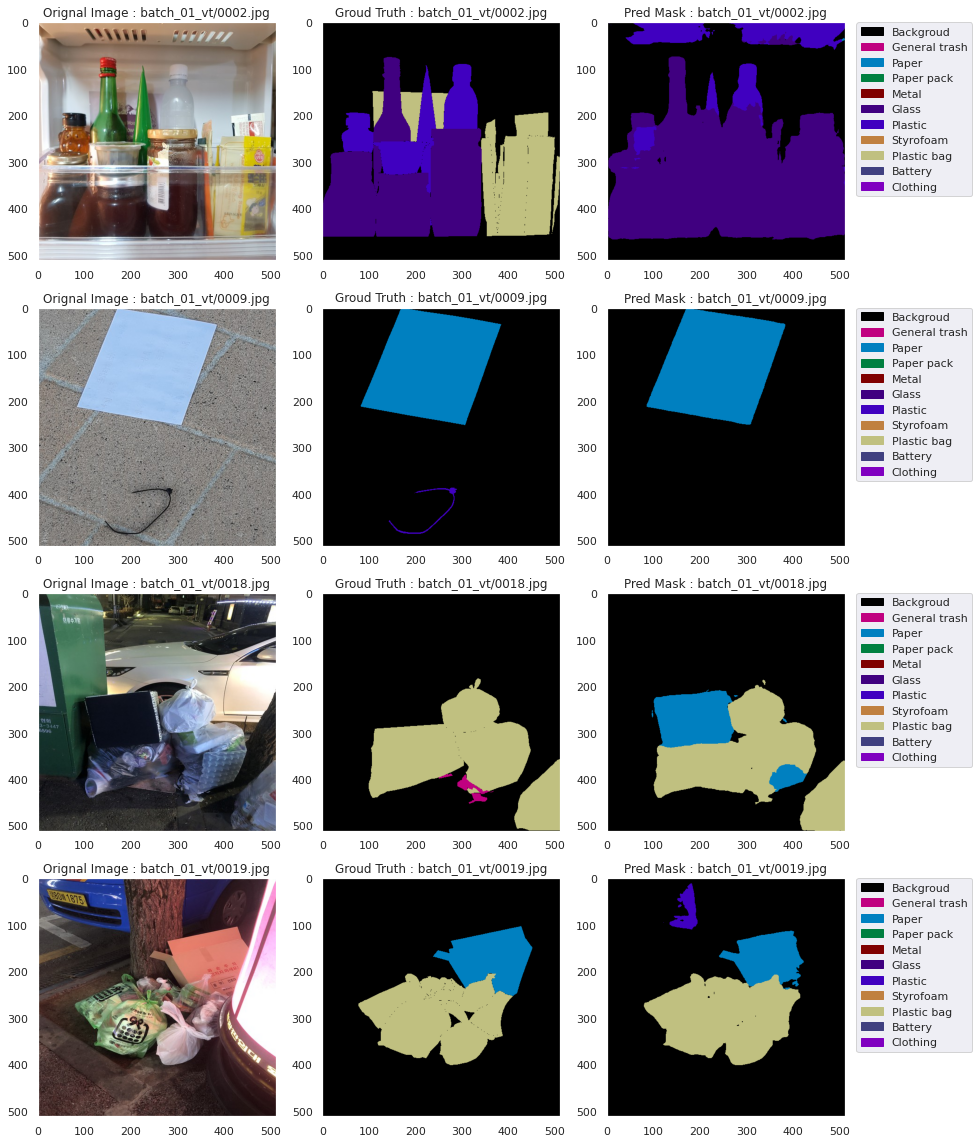

In [51]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

In [1]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

NameError: name 'plot_examples' is not defined

## submission을 위한 test 함수 정의

In [25]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [27]:
# sample_submisson.csv 열기
submission = pd.read_csv('../submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("../submission.csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 52/52 [04:53<00:00,  4.52s/it]


End prediction.
